In [1]:
#import all dependencies

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [7]:
#Reading data
dnameth = pd.read_csv("G9_liver_dna-meth.csv")
mystery = pd.read_csv("mystery_dna-meth.csv")

#Pre-processing data
dnameth.dropna()
dnameth.iloc[:, 1].unique()
dnameth = dnameth.rename(columns = {'Primary Tumor':'0'})

mystery.dropna()
mystery.iloc[:, 1].unique()
mystery.rename(columns = {'Primary Tumor':'0'})


#Defining dependant variable
y = dnameth['Label'].values
y_myst = mystery['Label'].values


#Encoding categorical data
Labelencoder = LabelEncoder()
Y_encoding = Labelencoder.fit_transform(y) # Primary Tumor = 0, Solid Tissue Normal = 1
y_mystencoding = Labelencoder.fit_transform(y_myst)

# Define the independent variables to drop the Label and Unnamed: 0
X = dnameth.drop(labels = ['Label','Unnamed: 0'], axis = 1)
X_myst = mystery.drop(labels = ['Label','Unnamed: 0'], axis = 1)
feature_names = np.array(X.columns)



In [9]:
#Normalisation
scaler = StandardScaler()
scaler.fit(X)
X_scale = scaler.transform(X)
X_log2 = np.log2(X)
X_log2 = scaler.fit_transform(X_log2)
X_train, X_test, Y_train, Y_test = train_test_split(X_scale, Y_encoding, test_size = 0.3, random_state = 42)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

scaler.fit(X_myst)
X_mystscale = scaler.transform(X_myst)

c:\Users\oolba\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\oolba\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [4]:
# Hyperparameters
learning_rate = 0.00013
epochs = 1000

# Variables for controlling the test example
test_example = torch.tensor(X_test, dtype=torch.float32)


# Variables
X = torch.tensor(X_train, dtype=torch.float32)
Y = torch.tensor(Y_train, dtype=torch.float32)
w = torch.tensor(0.0, requires_grad=True)
b = torch.tensor(0.0, requires_grad=True)


num_samples, num_features = X.shape


input_size = num_features
output_size = num_samples

class Detector(nn.Module):
    
    def __init__(self, input_dim, output_dim):
        super(Detector, self).__init__()    
        self.lin = nn.Linear(input_dim, output_dim)
        
    def forward(self, x):
        return self.lin(x)

model = Detector(input_size, output_size)    


loss = nn.MSELoss()
loss_over_time = []
optimiser = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [5]:
# Training loop
for epoch in range(epochs):

    total_loss = 0
    
    for i in range(num_samples):

        # Forward pass
        y_pred = model(X[i])
    
        # Calculate Loss
        l = loss(y_pred, Y[i])
        
        # Calculate gradients
        l.backward()

        total_loss += float(l)
    
    print(total_loss)
    loss_over_time.append(total_loss)
    # Update weights
    optimiser.step()
    optimiser.zero_grad()

c:\Users\oolba\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([298])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


227.7128780633211
220.18937747180462
214.93874359875917
211.1662561967969
208.35874047130346
206.18461833149195
204.42945517227054
202.95439052581787
201.66933810710907
200.51569320634007
199.45517501235008
198.46264933422208
197.52148001641035
196.62054505944252
195.75229460000992
194.91150035709143
194.0944653749466
193.29849426448345
192.52155270799994
191.7620499804616
191.0187104716897
190.29045775160193
189.57637483626604
188.8756512440741
188.1875602044165
187.51144499704242
186.84669679030776
186.19276120141149
185.54911310970783
184.91526901349425
184.29076673835516
183.67518443241715
183.06811828538775
182.4691921249032
181.8780464567244
181.29434594511986
180.7177793867886
180.14804499223828
179.58485927805305
179.02795896306634
178.47709169611335
177.93202270939946
177.3925281688571
176.85838981717825
176.32941425591707
175.80540852621198
175.28619946166873
174.7716090232134
174.26148340851068
173.75566526129842
173.25401483476162
172.75639268755913
172.26266965270042
171.7

True positives:  13
True negatives:  114
False positives:  2
False negatives:  0
Accuracy:  0.9844961240310077


Text(0, 0.5, 'Total Mean Squared Error')

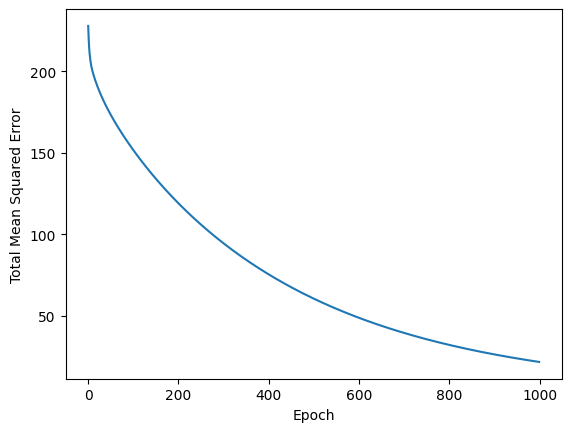

In [6]:
with torch.inference_mode():
    prediction = model(test_example)
    #print(f'Prediction after training = {test_example.item()} * {factor} = {prediction.item():.3f}')
rounded_prediction = []
mean = 0;
for row in prediction:
    mean = int(torch.round(torch.mean(row)))
    rounded_prediction.append(mean)


tp = 0
tn = 0
fp = 0
fn = 0
i = 0
for val in Y_test:
    if val == 1 and rounded_prediction[i] == 1:
        tp += 1
    if val == 0 and rounded_prediction[i] == 0:
        tn += 1
    if val == 0 and rounded_prediction[i] == 1:
        fp += 1
    if val == 1 and rounded_prediction[i] == 0:
        fn += 1
    i += 1

print("True positives: ", tp)
print("True negatives: ", tn)
print("False positives: ", fp)
print("False negatives: ", fn)
print("Accuracy: ", ((tn+tp)/(tp+tn+fp+fn)))

plt.plot(loss_over_time)
plt.xlabel("Epoch")
plt.ylabel("Total Mean Squared Error")

In [10]:
new_X = []
for subarr in X_mystscale:
    new_X.append(subarr[np.isfinite(subarr)])




Xmyst = torch.tensor(new_X, dtype=torch.float32)
Ymyst = torch.tensor(y_mystencoding, dtype=torch.float32)


with torch.inference_mode():
    prediction = model(Xmyst)
    #print(f'Prediction after training = {test_example.item()} * {factor} = {prediction.item():.3f}')
rounded_prediction = []
mean = 0;
for row in prediction:
    mean = int(torch.round(torch.mean(row)))
    rounded_prediction.append(mean)


tp = 0
tn = 0
fp = 0
fn = 0
i = 0
for val in Ymyst:
    if val == 1 and rounded_prediction[i] == 1:
        tp += 1
    if val == 0 and rounded_prediction[i] == 0:
        tn += 1
    if val == 0 and rounded_prediction[i] == 1:
        fp += 1
    if val == 1 and rounded_prediction[i] == 0:
        fn += 1
    i += 1

    print("True positives: ", tp)
    print("True negatives: ", tn)
    print("False positives: ", fp)
    print("False negatives: ", fn)
    print("Accuracy: ", ((tn+tp)/(tp+tn+fp+fn)))


True positives:  0
True negatives:  1
False positives:  0
False negatives:  0
Accuracy:  1.0
True positives:  0
True negatives:  2
False positives:  0
False negatives:  0
Accuracy:  1.0
True positives:  0
True negatives:  3
False positives:  0
False negatives:  0
Accuracy:  1.0
True positives:  0
True negatives:  4
False positives:  0
False negatives:  0
Accuracy:  1.0
True positives:  0
True negatives:  5
False positives:  0
False negatives:  0
Accuracy:  1.0
True positives:  0
True negatives:  6
False positives:  0
False negatives:  0
Accuracy:  1.0
True positives:  0
True negatives:  7
False positives:  0
False negatives:  0
Accuracy:  1.0
True positives:  0
True negatives:  8
False positives:  0
False negatives:  0
Accuracy:  1.0
True positives:  0
True negatives:  9
False positives:  0
False negatives:  0
Accuracy:  1.0
True positives:  0
True negatives:  10
False positives:  0
False negatives:  0
Accuracy:  1.0
True positives:  0
True negatives:  11
False positives:  0
False nega

C:\Users\oolba\AppData\Local\Temp\ipykernel_22736\113622495.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  Xmyst = torch.tensor(new_X, dtype=torch.float32)


IndexError: list index out of range